# Kuvantunnistus omista kuvista
Tunnistetaan kuvia aterimista

In [75]:
# Importit
from keras.utils import to_categorical, image_dataset_from_directory
import pandas as pd
from keras import layers
from keras import models
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)

## Malli 1: Oman CNN mallin koulutus ja testaus:

### Aluksi rajataan kuvat omiin kansioihinsa
- 70% treenidataan
- 15% validointiin
- 15% lopulliseen testidataan

In [53]:
import os
import shutil
import random

# Define paths
input_folder = 'OriginalPhotos'  # Source folder containing images
output_folder = 'DatasetSplit'  # Destination folder for train/val/test split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Delete existing output folder if it exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Ensure output folders exist
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

# Function to copy files while maintaining folder structure
def split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio):
    for root, dirs, files in os.walk(input_folder):
        if not files:  # Skip directories without files
            continue

        # Get relative path to preserve folder structure
        relative_path = os.path.relpath(root, input_folder)

        # Create corresponding subfolders in train, val, and test
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(output_folder, split, relative_path), exist_ok=True)

        # Shuffle files to randomize the split
        random.shuffle(files)

        # Calculate split indices
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split files into train, val, and test
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Adjust for rounding issues to ensure val and test are equal
        while len(val_files) > len(test_files):
            test_files.append(val_files.pop())
        while len(test_files) > len(val_files):
            val_files.append(test_files.pop())

        # Copy files to respective folders
        for file in train_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'train', relative_path, file))
        for file in val_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'val', relative_path, file))
        for file in test_files:
            shutil.copy(os.path.join(root, file), os.path.join(output_folder, 'test', relative_path, file))

# Call the function
split_images(input_folder, output_folder, train_ratio, val_ratio, test_ratio)

print(f"Images have been split into train, validation, and test folders in '{output_folder}'")

Images have been split into train, validation, and test folders in 'DatasetSplit'


### Tuodaan ja valmistellaan kuvat
- Luokitellaan kuvat
- Laitetaan kuvat datasettiin

Kuvien luokittelut tulee automaattisesti kerasin image_dataset_from_directory -funktiolla.
Funktio tekee suurimman osan vaikeasta työstä.

In [54]:
imgSize = 224
imgPath = 'OriginalPhotos'
batchSize = 16

# Kopioi kuvat testi, train ja val kansioihin
# Testiin menee 20% kuvista, ja 80% menee train kansioon
# Jaetaan data 80/20 train/val


# Haetaan kuvat kansiosta ja luodaan DataFrame
train_dataset = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_dataset = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_dataset = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize, imgSize),
    batch_size=batchSize,
    color_mode="rgb",
    shuffle=True,
    seed=42
)

classNames = train_dataset.class_names
print('Class names: ', classNames)
classesAmount = len(train_dataset.class_names)

# image_dataset_from_directory() ilmeisesti automaattisesti normalisoi. Jos sen tekee uudestaan, niin kuvat on mustia.
'''# Rescaling layer
rescale = layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))
val_dataset = val_dataset.map(lambda x, y: (rescale(x), y))'''

Found 64 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 13 files belonging to 3 classes.
Class names:  ['Haarukat', 'Lusikat', 'Veitset']


'# Rescaling layer\nrescale = layers.Rescaling(1./255)\n\ntrain_dataset = train_dataset.map(lambda x, y: (rescale(x), y))\nval_dataset = val_dataset.map(lambda x, y: (rescale(x), y))'

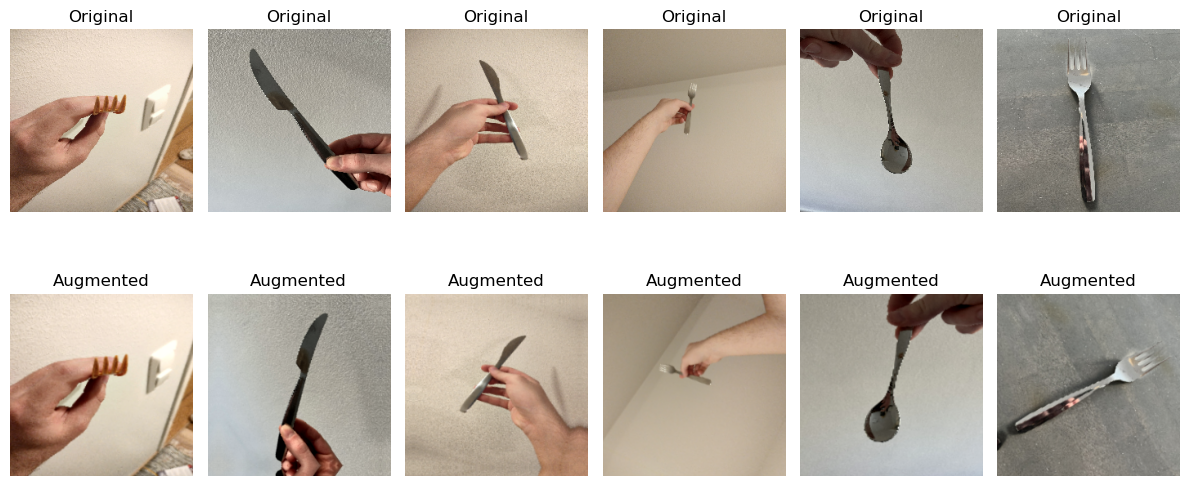

In [64]:
# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


# DEBUGATAAN AUGMENTAATIOTA ---------------------
# Select a batch of images from the training dataset
for images, labels in train_dataset.take(1):  # Take one batch
    break

# Apply data augmentation to the batch
augmented_images = data_augmentation(images)

# Plot the original and augmented images
plt.figure(figsize=(12, 6))

for i in range(6):  # Display 6 images
    # Original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 6, i + 7)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()
# -----------------------------------------------
# DEBUGATAAN AUGMENTAATIOTA ---------------------

### Treenaus

MILLAINEN ON MALLI?

In [62]:
l2Reg = regularizers.l2(0.002)

# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Mallin kerrokset
model = models.Sequential([
    layers.Input(shape=(imgSize, imgSize, 3)),

    data_augmentation,

    layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2Reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(0.4),

    layers.Dense(classesAmount, activation='softmax')  # Output layer
])


early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Koulutetaan malli
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    verbose=0,
    callbacks=[early_stopping]
)

print("Koulutus valmis!")
print("Accuracy: ", history.history['accuracy'][-1])
print("Validation Accuracy: ", history.history['val_accuracy'][-1])
print("Loss: ", history.history['loss'][-1])
print("Validation Loss: ", history.history['val_loss'][-1])


# DEBUGAUS -------------------------------------------------------------
predictions = model.predict(val_dataset)
print(np.argmax(predictions, axis=1))  # Predicted classes

for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    print("Predictions (probabilities):", predictions[:5])
    print("True labels:", labels.numpy()[:5])
print("Predicted classes:", np.argmax(predictions, axis=1)[:5])
print("True classes:", np.argmax(labels.numpy(), axis=1)[:5])
# DEBUGAUS -------------------------------------------------------------


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_54 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 222, 222, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │     2,986,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,987,731 (11.40 MB)

 Trainable params: 2,987,683 (11.40 MB)

 Non-trainable params: 48 (192.00 B)

Koulutus valmis!
Accuracy:  0.609375
Validation Accuracy:  0.46666666865348816
Loss:  1.3845396041870117
Validation Loss:  2.659226894378662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
[0 2 1 1 2 1 0 0 1 1 0 1 2 1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predictions (probabilities): [[3.1506050e-01 3.9155599e-01 2.9338345e-01]
 [2.3428060e-02 4.7648969e-01 5.0008225e-01]
 [1.3978343e-03 9.9788409e-01 7.1804260e-04]
 [5.2717227e-01 6.7522459e-02 4.0530524e-01]
 [1.0235069e-02 3.7552774e-01 6.1423719e-01]]
True labels: [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Predicted classes: [1 2 1 0 2]
True classes: [2 1 2 2 2]


##### Piirretään:

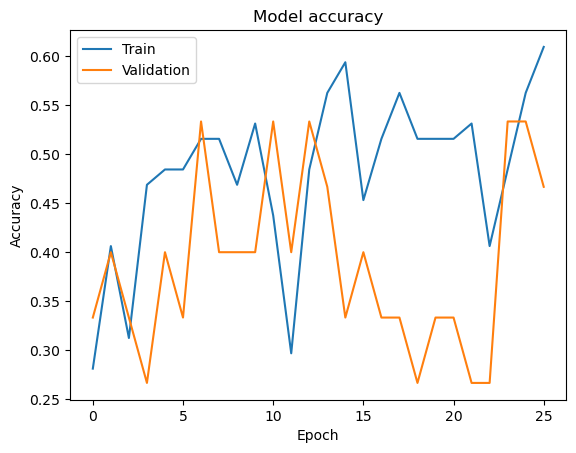

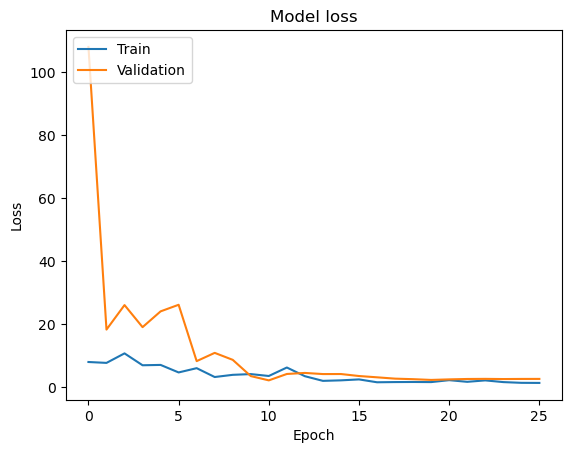

In [65]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Oman mallin analysointi:


## Malli 2: Esikoulutettu malli

In [71]:
from keras.applications import VGG16

# Set the image size to match VGG16 input requirements
imgSize_vgg = 224
batchSize_vgg = 8

# Annetaan VGG16 mallille samat datasetit, kuin edelliselle mallille
train_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/train',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

val_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/val',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)

test_dataset_vgg = image_dataset_from_directory(
    directory='DatasetSplit/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(imgSize_vgg, imgSize_vgg),
    batch_size=batchSize_vgg,
    color_mode="rgb",
    shuffle=True,
    seed=42,
)


Found 64 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 13 files belonging to 3 classes.


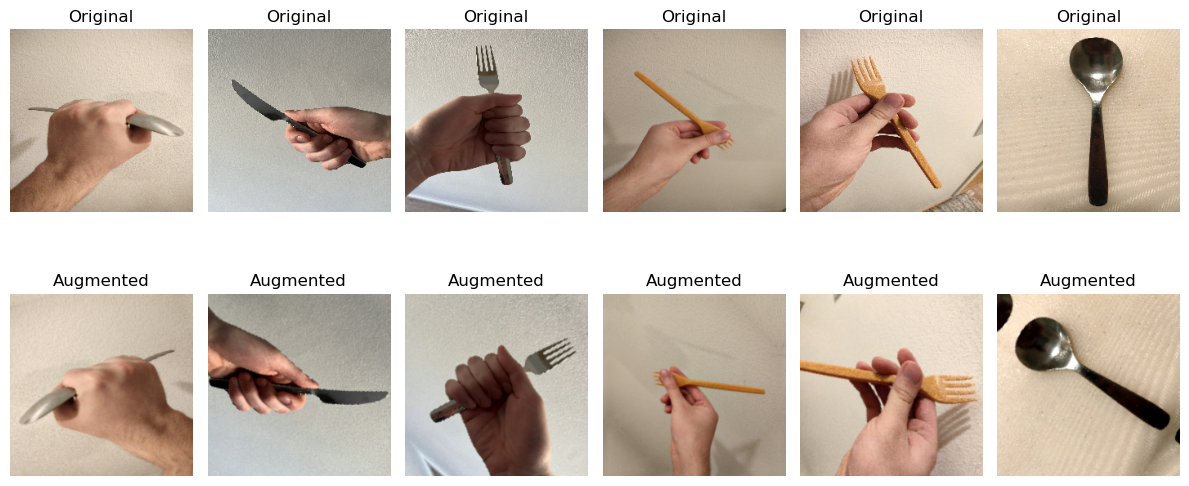

In [72]:
# Data augmentation kuville
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


# DEBUGATAAN AUGMENTAATIOTA ---------------------
# Select a batch of images from the training dataset
for images, labels in train_dataset_vgg.take(1):  # Take one batch
    break

# Apply data augmentation to the batch
augmented_images = data_augmentation(images)

# Plot the original and augmented images
plt.figure(figsize=(12, 6))

for i in range(6):  # Display 6 images
    # Original image
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 6, i + 7)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()
# -----------------------------------------------
# DEBUGATAAN AUGMENTAATIOTA ---------------------

In [77]:

# Load pre-trained VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(imgSize_vgg, imgSize_vgg, 3))

# Freeze the convolutional base to use it as a feature extractor
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
vgg_model = models.Sequential([
    base_model, # Aiemmin otettu VGG16 malli
    # VGG mallin jälkeen lisätään omat kerrokset:
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2Reg),
    layers.Dropout(0.4),
    layers.Dense(classesAmount, activation='softmax')
])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

seOptimizer = optimizers.Adam(learning_rate=0.001)

vgg_model.compile(
    optimizer=seOptimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

vgg_history = vgg_model.fit(
    train_dataset_vgg,
    validation_data=val_dataset_vgg,
    epochs=150,
    verbose=0,
    callbacks=[early_stopping]
)

print("Training complete!")
print("Accuracy: ", vgg_history.history['accuracy'][-1])
print("Validation Accuracy: ", vgg_history.history['val_accuracy'][-1])
print("Loss: ", vgg_history.history['loss'][-1])
print("Validation Loss: ", vgg_history.history['val_loss'][-1])

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,320,579 (62.26 MB)

 Trainable params: 1,605,891 (6.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Training complete!
Accuracy:  0.96875
Validation Accuracy:  0.6000000238418579
Loss:  0.6834266185760498
Validation Loss:  5.591208457946777


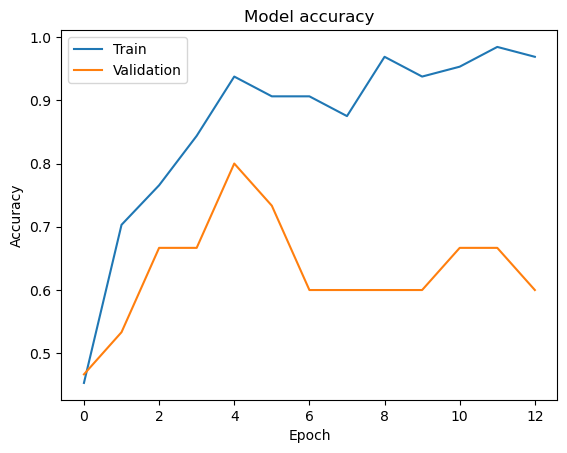

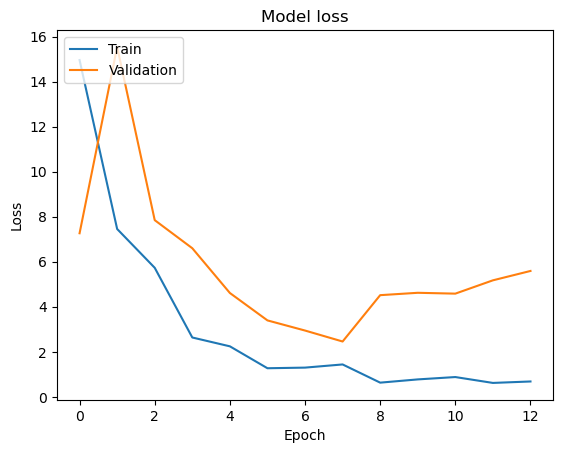

In [78]:
# Näytetään mallin treenihistoria
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Plot training & validation accuracy values
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Vaihe 3: RAPORTTI ja Analysointi: